In [ ]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .


Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793132 sha256=d69b2d78c067eb4d5b1e56f6b80a0ec55e609327fc157d04ed81968a02055f9d
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existi

In [ ]:
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym
# Copy the name of the Perceptual Decision Making environment from here: https://neurogym.github.io/envs/index.html
task_name = 'PerceptualDecisionMaking-v0'
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
class Reg_WD(torch.nn.Module):

    """A regulariser for spatially embedded RNNs.
  Applies L1 regularisation to recurrent kernel of
  RNN which is weighted by the distance of units
  in predefined 3D space.
  Calculation:
      reg_WD * sum[distance_matrix o recurrent_kernel]
  Attributes:
      reg_WD: Float; Weighting of Reg_WD regularisation term.
      network_structure: Defines a 3D grid specifying the
      dimensions of a 3D space where neurons are placed.
      The tuple specifies the range of coordinates along
      each of the three axes in this 3D space.
  """

    def __init__(self, reg_WD=0.01, neuron_num=100, network_structure=(5,5,4), coordinates_list=None, distance_power=1, distance_metric='euclidean'):
        super(Reg_WD, self).__init__()

        self.distance_power = distance_power
        self.reg_WD = torch.tensor([reg_WD], dtype=torch.float32)

        # Set up tensor with distance matrix
        nx = np.arange(network_structure[0])
        ny = np.arange(network_structure[1])
        nz = np.arange(network_structure[2])

        # Set up coordinate grid
        x, y, z = np.meshgrid(nx, ny, nz)
        self.coordinates = [x.ravel(), y.ravel(), z.ravel()]

        # Override coordinate grid if provided in init
        if coordinates_list is not None:
            self.coordinates = coordinates_list

        # Check neuron number / number of coordinates
        if (len(self.coordinates[0]) == neuron_num) and (len(self.coordinates[1]) == neuron_num) and (len(self.coordinates[2]) == neuron_num):
            pass
        else:
            raise ValueError('Network / coordinate structure does not match the number of neurons.')

        # Calculate the euclidean distance matrix
        euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates), metric=distance_metric)
        euclidean = scipy.spatial.distance.squareform(euclidean_vector ** self.distance_power)
        self.distance_matrix = torch.tensor(euclidean, dtype=torch.float32)

    def forward(self, x):
        abs_weight_matrix = torch.abs(x)
        WD_loss = self.reg_WD * torch.sum(abs_weight_matrix * self.distance_matrix)
        return WD_loss

    def _check_penalty_number(self, x):
        if not isinstance(x, (float, int)):
            raise ValueError(('Value: {} is not a valid regularization penalty number, '
                              'expected an int or float value').format(x))

    def visualise_distance_matrix(self):
        plt.imshow(self.distance_matrix.numpy())
        plt.colorbar()
        plt.show()

    def visualise_neuron_structure(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(self.coordinates[0], self.coordinates[1], self.coordinates[2], c='b', marker='.')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    def get_config(self):
        return {'reg_WD': float(self.reg_WD)}


In [ ]:
class seRNN(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
        device: str,
        add_noise: bool = True,
        noise_std: float = 0.05,
    ):
        super(seRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.add_noise = add_noise
        self.noise_std = noise_std

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)




    def forward(self, x):
        if self.add_noise:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        rnn_output, _ = self.rnn(x)
        out = self.output_layer(rnn_output[:, -1, :])
        return out, rnn_output



In [ ]:
%%capture
import logging

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

#Environment
task = 'DelayComparison-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n


Step 200, Loss 0.0791
Step 400, Loss 0.0311
Step 600, Loss 0.0303
Step 800, Loss 0.0301
Step 1000, Loss 0.0309
Step 1200, Loss 0.0296
Step 1400, Loss 0.0300
Step 1600, Loss 0.0302
Step 1800, Loss 0.0295
Step 2000, Loss 0.0304
Step 2200, Loss 0.0300
Step 2400, Loss 0.0302
Step 2600, Loss 0.0299
Step 2800, Loss 0.0295
Step 3000, Loss 0.0299
Step 3200, Loss 0.0297
Step 3400, Loss 0.0301
Step 3600, Loss 0.0297
Step 3800, Loss 0.0298
Step 4000, Loss 0.0304
Step 4200, Loss 0.0300
Step 4400, Loss 0.0303
Step 4600, Loss 0.0294
Step 4800, Loss 0.0298
Step 5000, Loss 0.0298
Epoch [1/10], cost: 11.5862
Step 200, Loss 0.0298
Step 400, Loss 0.0297
Step 600, Loss 0.0298
Step 800, Loss 0.0297
Step 1000, Loss 0.0304
Step 1200, Loss 0.0300
Step 1400, Loss 0.0301
Step 1600, Loss 0.0299
Step 1800, Loss 0.0300
Step 2000, Loss 0.0296
Step 2200, Loss 0.0303
Step 2400, Loss 0.0300
Step 2600, Loss 0.0298
Step 2800, Loss 0.0297
Step 3000, Loss 0.0298
Step 3200, Loss 0.0299
Step 3400, Loss 0.0296
Step 3600, Los

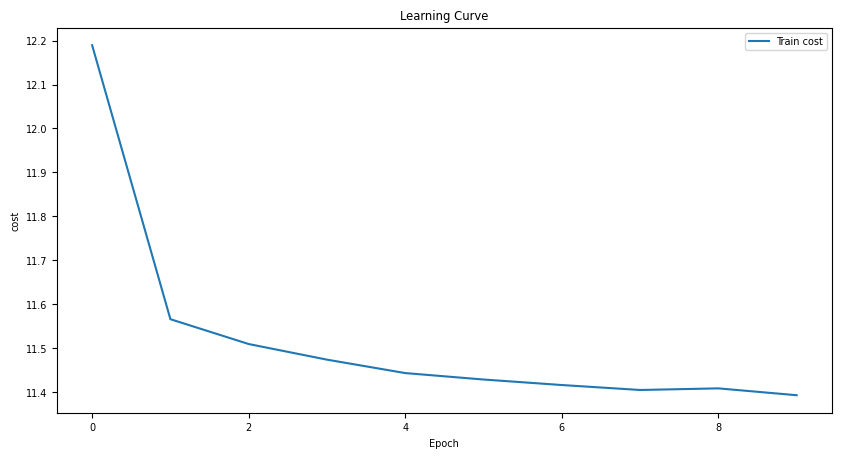

In [ ]:
import torch.optim as optim
from torch.nn.functional import cross_entropy


logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

device = "cuda" if torch.cuda.is_available() else "cpu" # Define 'device' here

# Instantiate the network
RNN_net = seRNN(input_size=input_size, hidden_size=100,num_layers=1, num_classes=output_size, device="cuda" if torch.cuda.is_available() else "cpu").to(device)


# Use Adam optimizer
optimizer = optim.Adam(RNN_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


WD_regularizer = Reg_WD(reg_WD=0.3,neuron_num=100,network_structure=(5,5,4))

# To store RNN weight matrices
rnn_weight_matrices = []

train_cost = []


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    RNN_net.train()
    epoch_cost = 0.0  # Reset cost for each epoch
     # Iterate through the dataset in batches
    print_step = 200
    loss_values = []  # List to store loss values
    running_loss = 0.0
    for i in range(5000):
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)  # Move inputs to device
        # Reshape labels to [batch_size] instead of flattening
        labels = torch.from_numpy(labels[:, -1]).type(torch.long).to(device)  # Move labels to device and select last element

        # Forward pass through the model
        outputs, activity = RNN_net(inputs)

        # Compute the main cost (cross-entropy loss)
        cost = criterion(outputs, labels)

        # Regularization cost (weight decay on RNN hidden layer weights)
        WD_cost = WD_regularizer(RNN_net.rnn.weight_hh_l0)
        total_cost = cost + WD_cost
        epoch_cost += total_cost.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        total_cost.backward()
        optimizer.step()

        # Update running loss
        running_loss += cost.item()
        if i % print_step == (print_step - 1):
            average_loss = running_loss / print_step
            print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
            loss_values.append(average_loss)  # Append average loss here
            running_loss = 0.0

    # Average epoch cost
    epoch_cost /= 5000
    train_cost.append(epoch_cost)

    # Log RNN weight matrices after each epoch
    rnn_weight_matrices.append(RNN_net.rnn.weight_ih_l0.detach().clone())

    # Validation (can be done similarly using val_loader if you have a validation set)
    RNN_net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(5000):  # Assuming this includes validation data
            inputs, labels = dataset()
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)  # Move inputs to device
            # Reshape labels to [batch_size] instead of flattening
            labels = torch.from_numpy(labels[:, -1]).type(torch.long).to(device)  # Move labels to device and select last element

            outputs, activity = RNN_net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == (labels)).sum().item()

    # Print epoch cost
    print(f"Epoch [{epoch+1}/{num_epochs}], cost: {total_cost.item():.4f}")

# Plotting the learning curve
# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_cost, label='Train cost')
plt.xlabel('Epoch')
plt.ylabel('cost')
plt.title('Learning Curve')
plt.legend()
plt.show()



In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

num_trial = 500
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = RNN_net(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})

# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Trial  0 {'ground_truth': 1, 'vpair': (22, 14), 'v1': 22, 'v2': 14, 'correct': False}
Trial  1 {'ground_truth': 2, 'vpair': (22, 14), 'v1': 14, 'v2': 22, 'correct': False}
Trial  2 {'ground_truth': 1, 'vpair': (30, 22), 'v1': 30, 'v2': 22, 'correct': False}
Trial  3 {'ground_truth': 1, 'vpair': (18, 10), 'v1': 18, 'v2': 10, 'correct': False}
Trial  4 {'ground_truth': 1, 'vpair': (30, 22), 'v1': 30, 'v2': 22, 'correct': False}
Average performance 0.0


Text(0, 0.5, 'Activity')

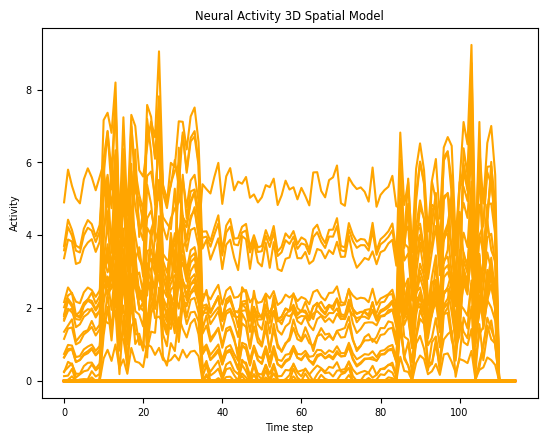

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

input_size = RNN_net.rnn.input_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial], color='orange', label='Neurons')
plt.title('Neural Activity 3D Spatial Model')
plt.xlabel('Time step')
plt.ylabel('Activity')


In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = RNN_net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.494


In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

ind_sort = np.argsort(selectivity)

AttributeError: 'RNN' object has no attribute 'h2h'

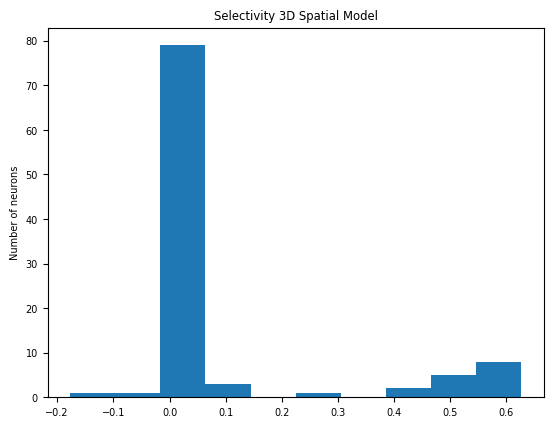

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.title('Selectivity 3D Spatial Model')
plt.ylabel('Number of neurons')

W = RNN_net.rnn.h2h.weight.detach().numpy()
# Sort by selectivity
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity 3D Spatial Model')

Shape of the neural activity (Time points, Neurons): (65000, 100)
Shape of the projected activity (Time points, PCs): (65000, 2)


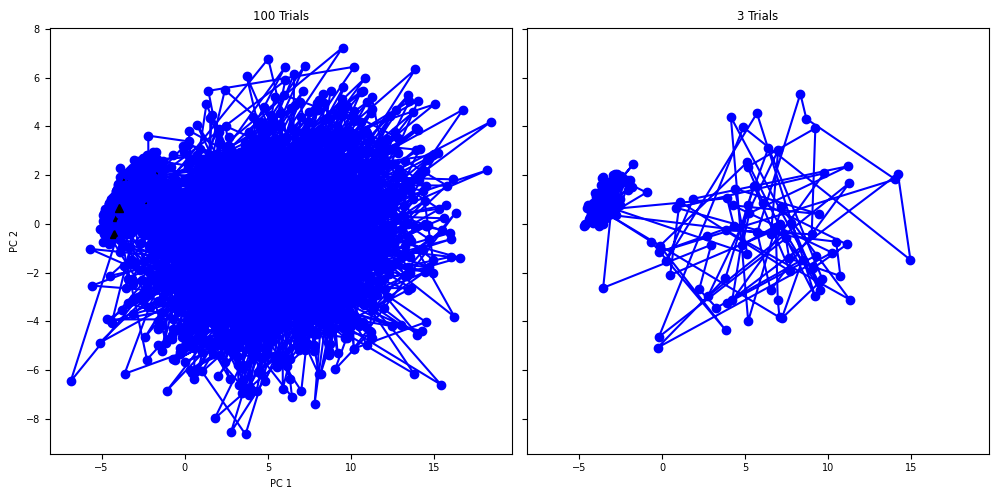

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN


In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)


        # Return None for output as per FixedPointFinder's requirement
        return None, hidden



In [ ]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(RNN_net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, RNN_net.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
inputs = torch.zeros(10, RNN_net.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Reshape initial hidden states for FixedPointFinder
init_hidden_np = init_hidden_np[:, np.newaxis, :]  # Add a new axis to match (batch_size, seq_len, hidden_size)
init_hidden_np = init_hidden_np.reshape(init_hidden_np.shape[0], 1, init_hidden_np.shape[-1])  # Reshape to (10, 1, 100)


# Find fixed points (CHeck FixedPointFinder documentation)
fixed_points_result = finder.find_fixed_points(initial_states= init_hidden_np, inputs= inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()




Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.


RuntimeError: For batched 3-D input, hx should also be 3-D but got 4-D tensor

In [ ]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, RNN_net.rnn.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()